In [13]:
import numpy as np
import pandas as pd 
import tushare as ts
import seaborn as sns;sns.set()
%matplotlib inline
import warnings;warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

stationary-->price Delta
priceDelta-->normal(假设服从正态分布)


y = ax + b + N(0,1)
N(0,1) = y-ax-b  (stationary) 找到了线性组合
标准化standardization,找到zscore

## 获取金融数据

In [4]:
data1 = ts.get_k_data('600199','2018-01-01','2019-05-31')[['date','close']]
data2 = ts.get_k_data('600702','2018-01-01','2019-05-31')['close']
data = pd.concat([data1,data2], axis=1)

In [5]:
data.set_index('date',inplace=True)

In [6]:
stocks_pair = ['600199','600702']

In [9]:
data.columns = stocks_pair

In [10]:
data.head(10)

,600199,600702
date,,
2018-01-02,7.758,45.771
2018-01-03,7.808,45.442
2018-01-04,7.897,45.861
2018-01-05,7.847,45.242
2018-01-08,7.897,43.874
2018-01-09,8.187,43.295
2018-01-10,8.097,44.044
2018-01-11,8.007,44.284
2018-01-12,8.017,45.871


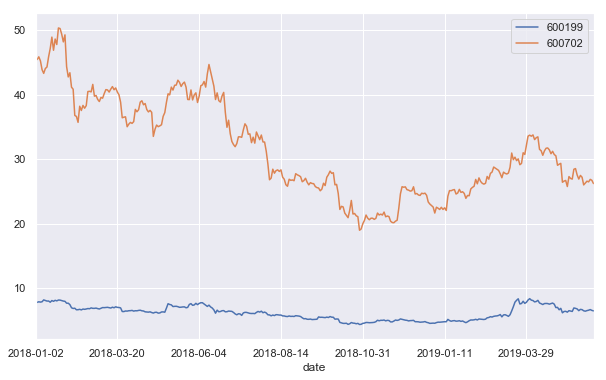

In [11]:
data.plot(figsize=(10,6))

## 策略开发思路

In [12]:
data.corr()   #计算方差及协方差矩阵

,600199,600702
600199,1.000000,0.825874
600702,0.825874,1.000000


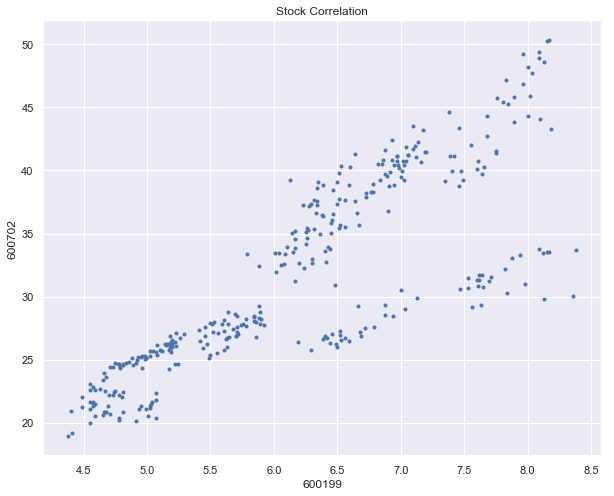

In [15]:
plt.figure(figsize=(10,8))
plt.title('Stock Correlation')
plt.plot(data['600199'],data['600702'],'.')
plt.xlabel('600199')
plt.ylabel('600702')
data.dropna(inplace=True)           #画出散点图看相关关系

In [18]:
[slope, intercept] = np.polyfit(data.iloc[:, 0],data.iloc[:, 1], 1).round(2)      #线性拟合，x,y,1(阶次)
slope, intercept

(5.81, -4.34)

In [19]:
data['spread'] = data.iloc[:,1]-intercept-slope*data.iloc[:,0]    #计算spread，spread是stationary的

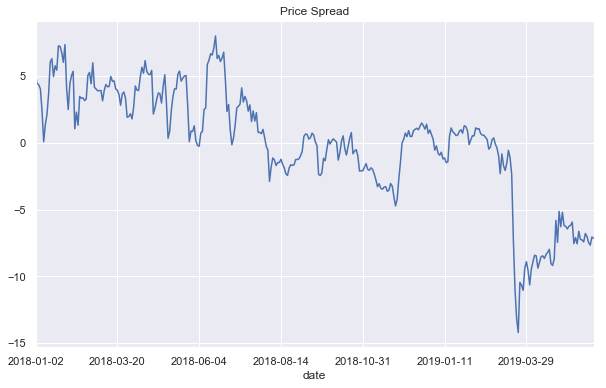

In [20]:
data['spread'].plot(figsize=(10,6), title='Price Spread')      #结果比之前假设直接股票价差stationary要合理一点

In [21]:
data['zscore'] = (data['spread']-data['spread'].mean())/np.std(data['spread'])

In [22]:
data.head()

,600199,600702,spread,zscore
date,,,,
2018-01-02,7.758,45.771,5.03702,1.188977
2018-01-03,7.808,45.442,4.41752,1.043537
2018-01-04,7.897,45.861,4.31943,1.020509
2018-01-05,7.847,45.242,3.99093,0.943387
2018-01-08,7.897,43.874,2.33243,0.554022


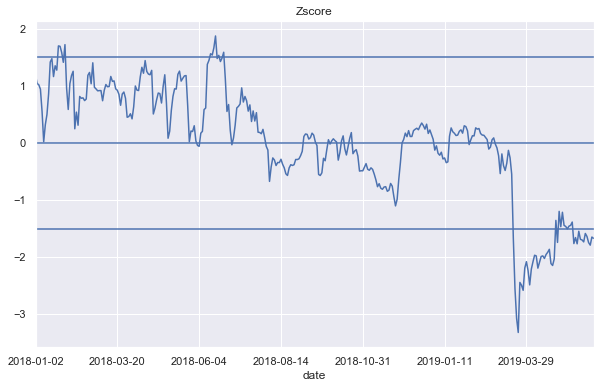

In [23]:
data['zscore'].plot(figsize=(10,6), title='Zscore')
plt.axhline(1.5)
plt.axhline(0)
plt.axhline(-1.5)

这里的交易信号跟之前的相反，做多做空的头寸不一样y = ax + b + N;这里是通过N得到的，如果N超过1.5，那么y价高short,x价低long

In [24]:
data['position_1'] = np.where(data['zscore']>1.5, 1,np.nan)
data['position_1'] = np.where(data['zscore']<-1.5, -1,data['position_1'])
data['position_1'] = np.where(abs(data['zscore'])<0.5, 0,data['position_1'])

In [25]:
data['position_1'] = data['position_1'].ffill()

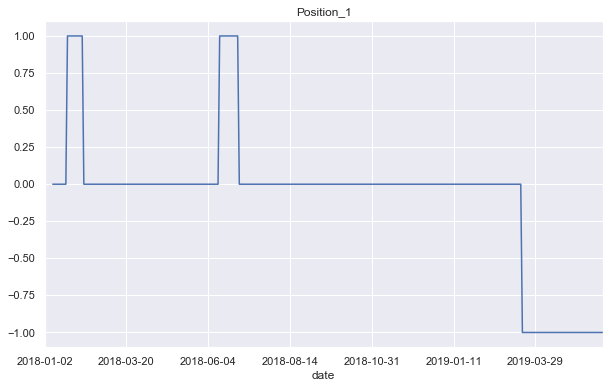

In [26]:
data['position_1'].plot(figsize=(10,6),title='Position_1')

In [27]:
data['position_2'] = -1*data['position_1']   

In [ ]:
# data['position_2'] = -np.sign(data['position_1'])

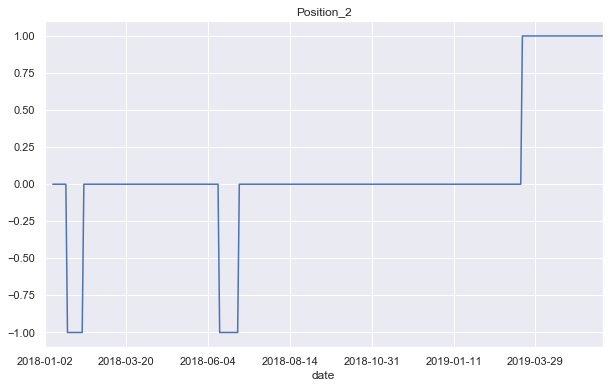

In [28]:
data['position_2'].plot(ylim=[-1.1,1.1],figsize=(10,6),title='Position_2')

## 计算策略收益并可视化

In [29]:
data['return_1'] = np.log(data['600199']/data['600199'].shift(1))
data['return_2'] = np.log(data['600702']/data['600702'].shift(1))

In [31]:
data['strategy'] = 0.5*data['position_1'].shift(1)*data['return_1'] + 0.5*data['position_2'].shift(1)*data['return_2']

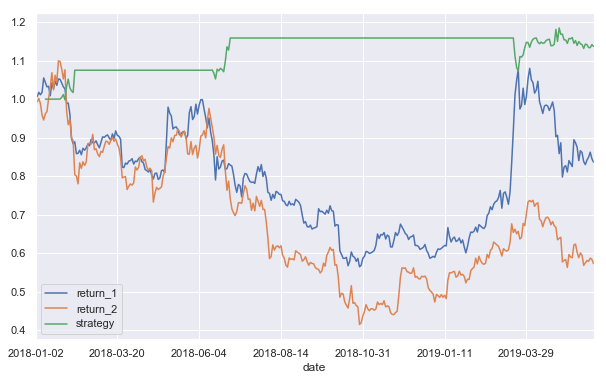

In [33]:
data[['return_1','return_2','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

策略思考
对多只ETF进行配对交易，是很多实盘量化基金的交易策略

风险
Spread不回归的风险
中国市场做空受限制，策略中有部分做空的收益是无法获得的
回归系数需要rebalance
策略没有考虑交易成本和其他成本